In [1]:
import sys
sys.path.append('../../')


from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.fftpack import fft
from scipy import stats # for zscoring

from sklearn.covariance import GraphicalLassoCV

from numpy.polynomial.polynomial import polyfit, polyval

import matplotlib.pyplot as plt

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, 

In [2]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes 

In [3]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [4]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)
    #plt.plot(w[1:500],20*np.log10(np.abs(h[1:500])))


In [5]:
# organize file in time sequence
filedir="../../"
pathname = 'Cleaned_data/'
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [59]:
# try one trial
ampdata=list()
phadata=list()
for ses in range(1):
    filename='clean_'+str(filedates[ses])+'.mat'
    [eeg, intervals, samples, condition_index, session, sr, bpchan, 
                condition_Names, channels, chan_labels, sessionTypes] \
                    = loaddata(filedir+pathname+filename)
    # make a low pass filter @ 50 Hz 
    sos_low, w,h = makefiltersos(sr,50,55)
    empirical_ampcorr = np.zeros((12,2,7,32,32))
    parcor = np.zeros((12,2,7,32,32))
    for trial in range(10,11):
        nsamp1 = np.shape(eeg[0][trial])[0]
        nsamp2 = np.shape(eeg[1][trial])[0]
        nsamp = np.min((nsamp1,nsamp2))
        for subject in range(1): 
            trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
            trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
            trialdatanew = trialdata[range(0,nsamp,downsample),:]
            for frequency in range(7):
                        filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
                        hilbertdata = hilbert(filtdata,axis = 0)
                        ampdata.append(np.abs(hilbertdata)) # amplitude
                        phadata.append(np.angle(hilbertdata))# phase
amp7data=np.transpose(np.concatenate((ampdata[0],ampdata[1],ampdata[2],ampdata[3],ampdata[4],ampdata[5],ampdata[6]),axis=1))
pha7data=np.transpose(np.concatenate((phadata[0],phadata[1],phadata[2],phadata[3],phadata[4],phadata[5],phadata[6]),axis=1))



In [60]:
[bandlabels*2][0]

['Delta',
 'Theta',
 'Alpha',
 'Mu',
 'Beta1',
 'Beta2',
 'Gamma',
 'Delta',
 'Theta',
 'Alpha',
 'Mu',
 'Beta1',
 'Beta2',
 'Gamma']

([<matplotlib.axis.YTick at 0x7f0d405b50d0>,
 [Text(0, 16, 'Delta'),
  Text(0, 48, 'Theta'),
  Text(0, 80, 'Alpha'),
  Text(0, 112, 'Mu'),
  Text(0, 144, 'Beta1'),
  Text(0, 176, 'Beta2'),
  Text(0, 208, 'Gamma'),
  Text(0, 240, 'Delta'),
  Text(0, 272, 'Theta'),
  Text(0, 304, 'Alpha'),
  Text(0, 336, 'Mu'),
  Text(0, 368, 'Beta1'),
  Text(0, 400, 'Beta2'),
  Text(0, 432, 'Gamma')])

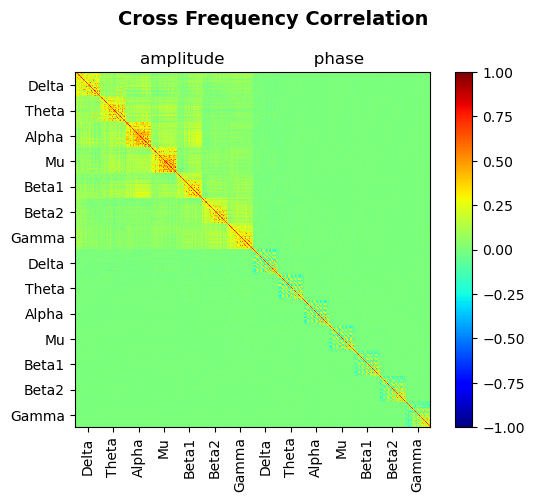

In [61]:
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
fig.suptitle('Cross Frequency Correlation', fontsize=14, fontweight='bold')
ax.set_title('amplitude                 phase')

plt.imshow(np.corrcoef(amp7data,pha7data),vmin = -1,vmax = 1, cmap = 'jet')
plt.colorbar()


x = np.array([16+32*i for i in range(7*2)])
y = np.array([16+32*i for i in range(7*2)])
my_xticks = [bandlabels*2][0]
my_yticks = [bandlabels*2][0]
plt.xticks(x, my_xticks,rotation='vertical')
plt.yticks(y, my_yticks)




In [62]:
[16+32*i for i in range(7)]

[16, 48, 80, 112, 144, 176, 208]

([<matplotlib.axis.YTick at 0x7f0d40548c10>,
 [Text(0, 16, 'Delta'),
  Text(0, 48, 'Theta'),
  Text(0, 80, 'Alpha'),
  Text(0, 112, 'Mu'),
  Text(0, 144, 'Beta1'),
  Text(0, 176, 'Beta2'),
  Text(0, 208, 'Gamma')])

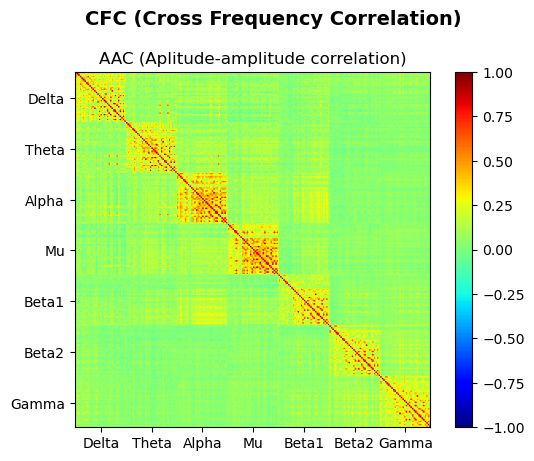

In [63]:
# I tried out Cross Frequency Correlation in one random trial.
# The result shows almost no cross frequency amplitude-phase and phase-phase correlation. 
# There are same frequency phase-phase correlation.
# And there are some cross frequency amplitude-amplitude correlation, insterestingly with delta-gamma coupling.



# Next step: extract within subject 224x224 AAC-CFC matricies.
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
fig.suptitle('CFC (Cross Frequency Correlation)', fontsize=14, fontweight='bold')
ax.set_title('AAC (Aplitude-amplitude correlation)')

AAC=np.corrcoef(amp7data,pha7data)[:224,:224]

plt.imshow(AAC,vmin = -1,vmax = 1, cmap = 'jet')
plt.colorbar()

x = np.array([16+32*i for i in range(7)])
y = np.array([16+32*i for i in range(7)])
my_xticks = bandlabels
my_yticks = bandlabels
plt.xticks(x, my_xticks)
plt.yticks(y, my_yticks)



Text(0, 0.5, 'channels (Delta)')

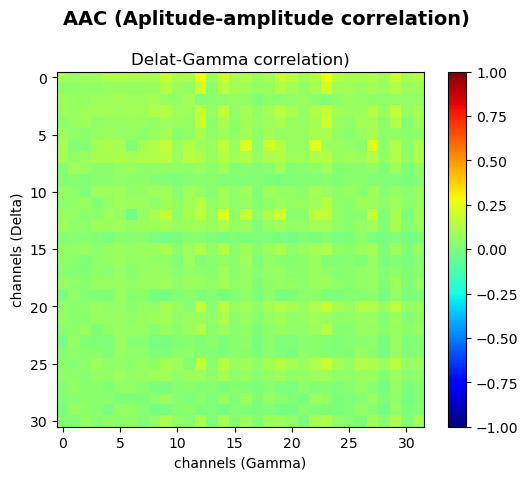

In [64]:
# Next step: extract within subject 224x224 AAC-CFC matricies.
fig = plt.figure()
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
fig.suptitle('AAC (Aplitude-amplitude correlation)', fontsize=14, fontweight='bold')
ax.set_title('Delat-Gamma correlation)')

AAC=np.corrcoef(amp7data,pha7data)[0:32, (224-32):224]

plt.imshow(AAC,vmin = -1,vmax = 1, cmap = 'jet')
plt.colorbar()

plt.xlabel('channels (Gamma)')
plt.ylabel('channels (Delta)')


In [93]:
ses=0
trial=0
ses != 0 | trial != 0

False

In [94]:
# try 12 session x 12 trials x 2 subjects 
# organize into 144 x 2 subject
AAC_Delta_Gamma_all=np.zeros((144,2,32,32))
n=0
for ses in range(12):
    filename='clean_'+str(filedates[ses])+'.mat'
    [eeg, intervals, samples, condition_index, session, sr, bpchan, 
                condition_Names, channels, chan_labels, sessionTypes] \
                    = loaddata(filedir+pathname+filename)
    # make a low pass filter @ 50 Hz 
    sos_low, w,h = makefiltersos(sr,50,55)
    empirical_ampcorr = np.zeros((12,2,7,32,32))
    parcor = np.zeros((12,2,7,32,32))
    for trial in range(12):
        nsamp1 = np.shape(eeg[0][trial])[0]
        nsamp2 = np.shape(eeg[1][trial])[0]
        nsamp = np.min((nsamp1,nsamp2))
        if ses != 0 | trial != 0: n+=1
        for subject in range(2): 
            trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
            trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
            trialdatanew = trialdata[range(0,nsamp,downsample),:]
            ampdata=list()
            phadata=list()
            for frequency in range(7):
                        filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
                        hilbertdata = hilbert(filtdata,axis = 0)
                        ampdata.append(np.abs(hilbertdata)) # amplitude
                        phadata.append(np.angle(hilbertdata))# phase
            # amp7data=np.transpose(np.concatenate((ampdata[0],ampdata[1],ampdata[2],ampdata[3],ampdata[4],ampdata[5],ampdata[6]),axis=1))
            # pha7data=np.transpose(np.concatenate((phadata[0],phadata[1],phadata[2],phadata[3],phadata[4],phadata[5],phadata[6]),axis=1))
            # AAC=np.corrcoef(amp7data,pha7data)[:224,:224]
            # AAC_Delta_Gamma=np.corrcoef(amp7data,pha7data)[0:32, (224-32):224]
            # AAC_Delta_Gamma_all[ses,trial,subject,:,:]=AAC_Delta_Gamma
            amp2data=np.transpose(np.concatenate((ampdata[0],ampdata[6]),axis=1))
            AAC_Delta_Gamma=np.corrcoef(amp2data)
            AAC_Delta_Gamma_all[n,subject,:,:]=AAC_Delta_Gamma[0:32,64-32:64]

# It took 7 min

In [100]:
outdict = dict()
# outdict['intervals144']         = intervals144
# outdict['samples144']           = samples144
outdict['AAC_Delta_Gamma_144']   = AAC_Delta_Gamma_all

savemat('AAC_Delta_Gamma_144',outdict,store_python_metadata = True) 

In [3]:
outdict=loadmat('AAC_Delta_Gamma_144.mat')
outdict.keys()
AAC_Delta_Gamma_144  = outdict['AAC_Delta_Gamma_144']

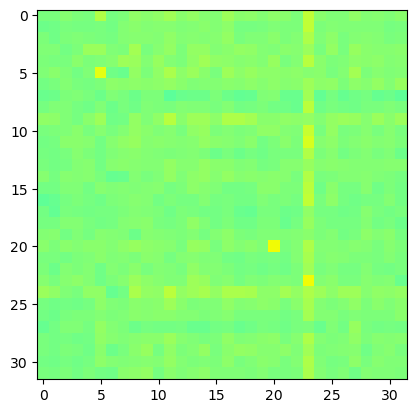

In [96]:
plt.imshow(AAC_Delta_Gamma[0:32,64-32:64],vmin = -1,vmax = 1, cmap = 'jet')

In [97]:
# get condition
# re_collect condition_index etc from raw files
# because somehow I lost condition_index in those files
# I don't know how that happenned
# intervals144         =dict()
# samples144           =dict()
condition_index144   =np.zeros((144))
session144           =np.zeros((144))
n=0
for ses in range(12):
	filename='clean_'+str(filedates[ses])+'.mat'
	[eeg, intervals, samples, condition_index, session, sr, bpchan, 
				condition_Names, channels, chan_labels, sessionTypes] \
					= loaddata(filedir+pathname+filename)
	for trl in range(12):
		# intervals144[str(n)]      = intervals[trl]
		# samples144[str(n)]        = samples[trl]
		condition_index144[n]     = condition_index[trl]    # 12
		session144[n]             = session
		n+=1

outdict = dict()
# outdict['intervals144']         = intervals144
# outdict['samples144']           = samples144
outdict['condition_index144']   = condition_index144
outdict['session144']           = session144

savemat('condition_ind144',outdict,store_python_metadata = True) 

In [2]:
outdict=loadmat('condition_ind144.mat')
outdict.keys()
condition_index144  = outdict['condition_index144']
session144          = outdict['session144']

In [ ]:
# select a session
fig, ax = plt.subplots(72,2,figsize=(6*2, 6*72))
# fig.subplots_adjust(top=0.99)
# fig.suptitle('AAC (Aplitude-amplitude correlation)', fontsize=14, fontweight='bold')

for n in range(72):
        for subject in range(2):
                plt.sca(ax[n, subject])
                ax[n, subject].set_title('condition ' + str(condition_index144[n+72]) + '  subject ' + str(subject))
                plt.imshow(AAC_Delta_Gamma_all[n+72,subject,:,:],vmin = -1,vmax = 1, cmap = 'jet')
                plt.colorbar()

# plt.suptitle('AAC (Aplitude-amplitude correlation)')

# There are correlation in some trials
# could maybe average condition together in the next step

In [4]:
# organize indicies
synch_ind=np.where(session144==1)
synco_ind=np.where(session144==2)

Uncoupled_ind=np.where(condition_index144==0)
L_lead_ind   =np.where(condition_index144==1)
R_lead_ind   =np.where(condition_index144==2)
Mutual_ind   =np.where(condition_index144==3)

# Uncoupled condition in Synch for L&R
Uncoupled_synch_ind=np.intersect1d(synch_ind,Uncoupled_ind)
# Uncoupled condition in Synco for L&R
Uncoupled_synco_ind=np.intersect1d(synco_ind,Uncoupled_ind)

# L_Leading in Synch / R_following in Synch
L_lead_synch_ind=np.intersect1d(synch_ind,L_lead_ind)
# L_Leading in Synco / R_following in Synco
L_lead_synco_ind=np.intersect1d(synco_ind,L_lead_ind)

# R_leading in Synch / L_following in Synch
R_lead_synch_ind=np.intersect1d(synch_ind,R_lead_ind)
# R_leading in Synco / L_following in Synco
R_lead_synco_ind=np.intersect1d(synco_ind,R_lead_ind)

# Mutual condition in Synch for L&R
Mutual_synch_ind=np.intersect1d(synch_ind,Mutual_ind)
# Mutual condition in Synco for L&R
Mutual_synco_ind=np.intersect1d(synco_ind,Mutual_ind)


In [5]:
outdict = dict()
outdict['synch_ind']       = synch_ind
outdict['synco_ind']       = synco_ind
outdict['syn_ind']       = [synch_ind, synco_ind]


outdict['Uncoupled_ind']        = Uncoupled_ind
outdict['L_lead_ind']           = L_lead_ind
outdict['R_lead_ind']           = R_lead_ind
outdict['Mutual_ind']           = Mutual_ind
outdict['L_lead_ind']           = L_lead_ind

condi4_ind                      = [Uncoupled_ind,L_lead_ind,R_lead_ind,Mutual_ind]
outdict['condi4_ind']           = condi4_ind

outdict['Uncoupled_synch_ind']  = Uncoupled_synch_ind
outdict['Uncoupled_synco_ind']  = Uncoupled_synco_ind
outdict['L_lead_synch_ind']     = L_lead_synch_ind
outdict['L_lead_synco_ind']     = L_lead_synco_ind
outdict['R_lead_synch_ind']     = R_lead_synch_ind
outdict['R_lead_synco_ind']     = R_lead_synco_ind
outdict['Mutual_synch_ind']     = Mutual_synch_ind
outdict['Mutual_synco_ind']     = Mutual_synco_ind

synch_condi4_ind                = [Uncoupled_synch_ind,L_lead_synch_ind,R_lead_synch_ind,Mutual_synch_ind]
outdict['synch_condi4_ind']     = synch_condi4_ind
synco_condi4_ind                = [Uncoupled_synco_ind,L_lead_synco_ind,R_lead_synco_ind,Mutual_synco_ind]
outdict['synco_condi4_ind']     = synco_condi4_ind

outdict['syn2_condi4_ind']      = [synch_condi4_ind, synco_condi4_ind]

savemat('Indicies',outdict,store_python_metadata = True) 

In [7]:
outdict=loadmat('Indicies.mat')

syn2_condi4_ind     = outdict['syn2_condi4_ind']

In [6]:
# variable names for plotting
states4names=['Uncoupled','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [26]:
# organize into 4 states
mean_AAC_Delta_Gamma_4con = np.zeros((2,4,32,32)) # from "AAC_Delta_Gamma_144.mat"
for syn in range(2):
    for con in range(4):
        concate_mat=np.concatenate((AAC_Delta_Gamma_144[syn2_condi4_ind[syn][con],0,:,:],
                                    AAC_Delta_Gamma_144[syn2_condi4_ind[syn][con],1,:,:]),axis=0)
        mean_mat=np.mean(concate_mat,axis=0)
        mean_AAC_Delta_Gamma_4con[syn,con,:,:]=mean_mat 


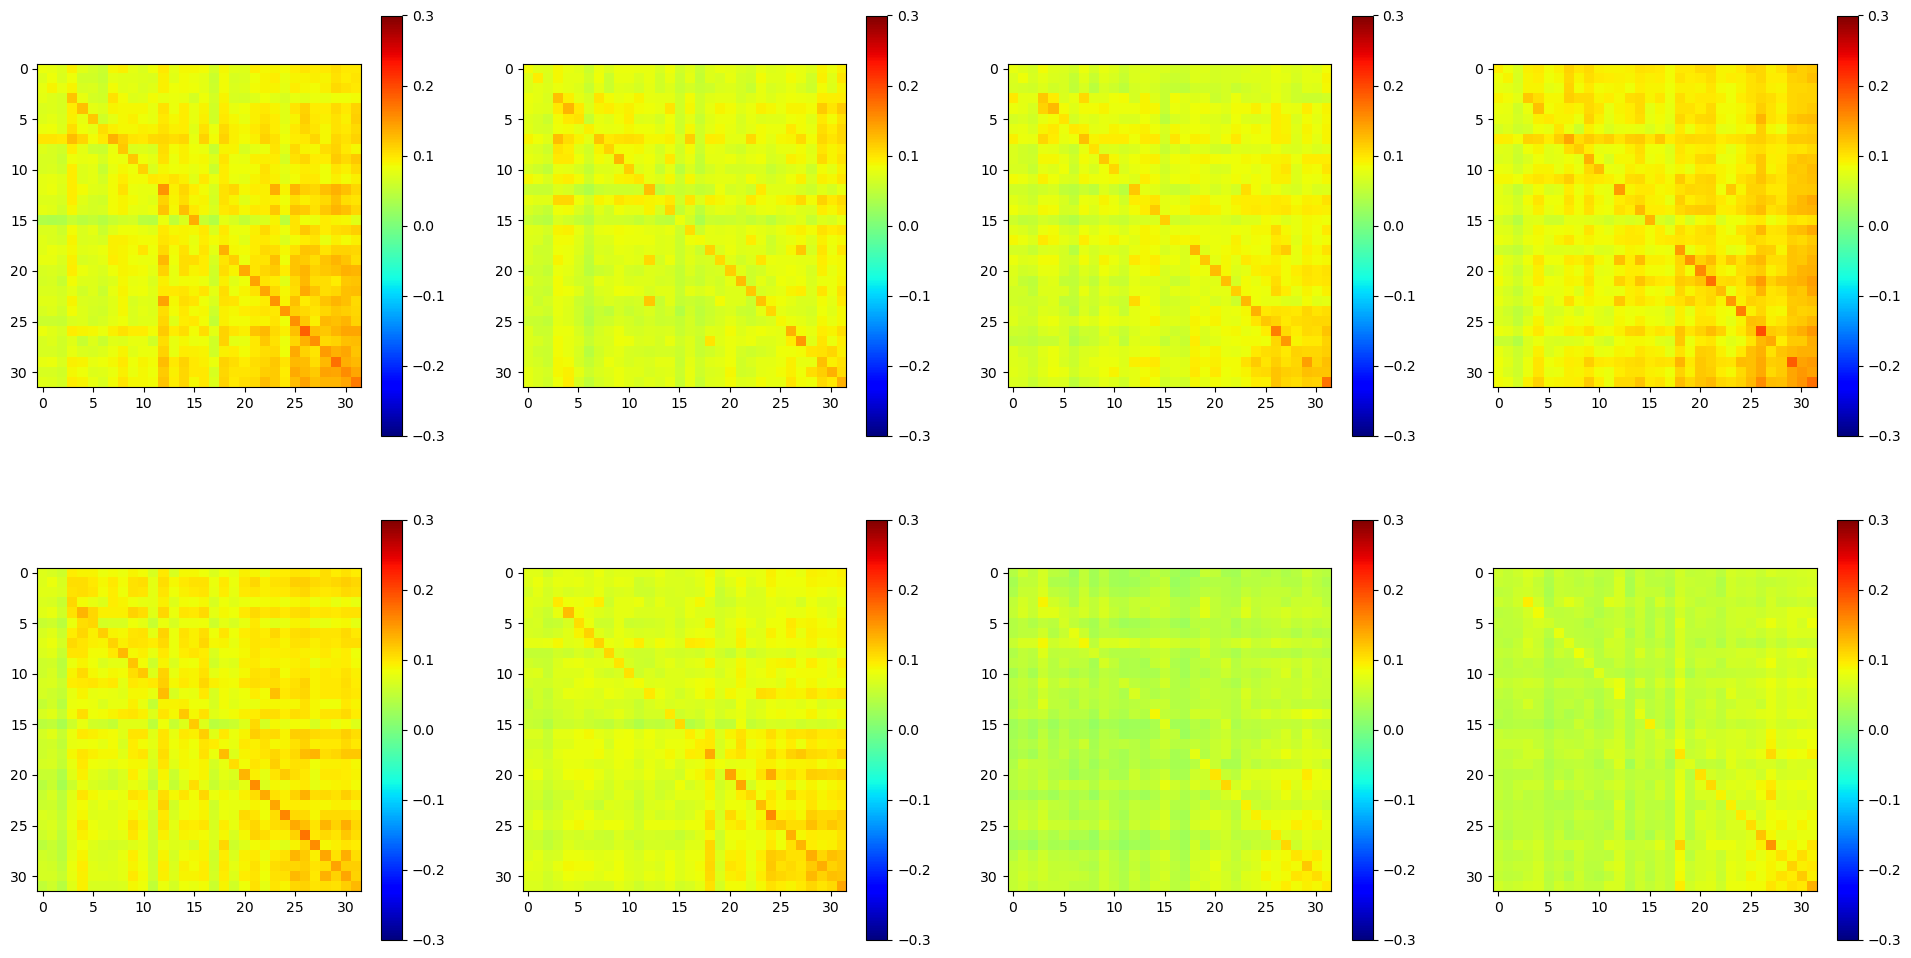

In [30]:
fig, ax = plt.subplots(2,4,figsize=(6*4, 6*2))
for syn in range(2):
    for con in range(4):
        plt.sca(ax[syn,con])
        plt.imshow(mean_AAC_Delta_Gamma_4con[syn,con,:,:],vmin = -0.3,vmax = 0.3, cmap = 'jet')
        plt.colorbar()


In [ ]:
# organize into 3 states

In [ ]:
fig, ax = plt.subplots(2,3,figsize=(6*4, 6*2))
for syn in range(2):
    for con in range(4):
        plt.sca(ax[syn,con])
        plt.imshow(mean_AAC_Delta_Gamma_4con[syn,con,:,:],vmin = -0.3,vmax = 0.3, cmap = 'jet')
        plt.colorbar()